In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [31]:
BATCH_SIZE = 50
IMAGE_SIZE = 48
CHANNELS=3
EPOCHS=50

In [32]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "FER+RAF",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 40973 files belonging to 7 classes.


In [33]:
class_names = dataset.class_names
class_names

['0', '1', '2', '3', '4', '5', '6']

In [34]:
len(dataset)

820

In [35]:
820*50

41000

In [36]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(50, 48, 48, 3)
[4 3 0 4 6 3 3 4 0 4 0 3 3 4 6 6 4 3 2 2 6 4 5 3 3 3 3 3 6 5 2 4 4 3 6 6 4
 4 3 4 3 4 5 2 3 4 3 2 3 5]


In [37]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[153.09027  121.09028  108.09028 ]
  [161.57292  129.57292  118.572914]
  [166.36632  134.36632  123.36632 ]
  ...
  [144.28468  123.86801  106.86801 ]
  [151.375    134.375    118.375   ]
  [138.26218  121.26217  105.26217 ]]

 [[157.73958  125.739586 114.739586]
  [168.26562  136.26562  125.265625]
  [167.27605  135.27605  124.27604 ]
  ...
  [147.625    126.322914 109.76562 ]
  [154.23438  136.45312  118.84375 ]
  [144.96356  127.96356  109.96356 ]]

 [[153.5      123.5      112.5     ]
  [162.02083  132.02083  121.020836]
  [173.62672  143.62672  133.62672 ]
  ...
  [146.87677  124.630226 108.33856 ]
  [143.0573   124.8073   107.4323  ]
  [159.7413   142.7413   124.741295]]

 ...

 [[205.75     178.62498  174.33331 ]
  [205.76562  178.64061  174.34895 ]
  [202.95659  175.83159  171.53992 ]
  ...
  [156.87506  142.71011  158.25    ]
  [135.15625  138.73958  166.11458 ]
  [131.6337   138.60765  170.86632 ]]

 [[199.20833  177.33333  168.95833 ]
  [203.75     181.875    173.5     ]


In [38]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)

(48, 48, 3)


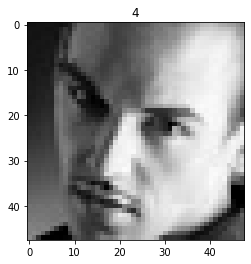

In [39]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
#     plt.axis("off")

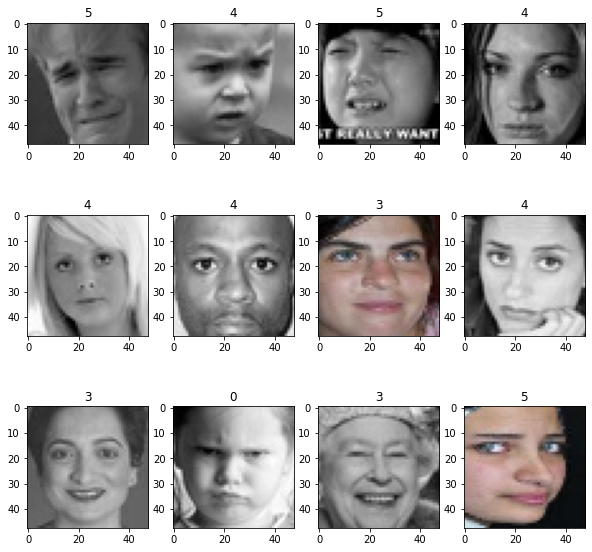

In [40]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
#         plt.axis("off")


In [41]:
len(dataset)

820

In [42]:

train_size = 0.8
len(dataset)*train_size

656.0

In [43]:
train_ds = dataset.take(656)
len(train_ds)

656

In [44]:
test_ds = dataset.skip(656)
len(test_ds)

164

In [45]:
val_size=0.1
len(dataset)*val_size

82.0

In [46]:
val_ds = test_ds.take(82)
len(val_ds)

82

In [47]:
test_ds = test_ds.skip(82)
len(test_ds)

82

In [48]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [49]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [50]:
len(train_ds)

656

In [51]:
len(val_ds)

82

In [52]:
len(test_ds)

82

In [53]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [55]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [56]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape=input_shape)

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (50, 48, 48, 3)           0         
                                                                 
 conv2d_4 (Conv2D)           (50, 46, 46, 32)          896       
                                                                 
 max_pooling2d_4 (MaxPooling  (50, 23, 23, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (50, 21, 21, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (50, 10, 10, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (50, 8, 8, 64)           

In [58]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [59]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
656/656 [==============================] - 100s 138ms/step - loss: 1.7394 - accuracy: 0.3088 - val_loss: 1.6198 - val_accuracy: 0.3540
Epoch 2/50
656/656 [==============================] - 66s 100ms/step - loss: 1.4333 - accuracy: 0.4589 - val_loss: 1.3213 - val_accuracy: 0.4979
Epoch 3/50
656/656 [==============================] - 56s 85ms/step - loss: 1.2460 - accuracy: 0.5314 - val_loss: 1.1631 - val_accuracy: 0.5686
Epoch 4/50
656/656 [==============================] - 58s 88ms/step - loss: 1.1522 - accuracy: 0.5693 - val_loss: 1.1446 - val_accuracy: 0.5716
Epoch 5/50
656/656 [==============================] - 58s 88ms/step - loss: 1.0885 - accuracy: 0.5926 - val_loss: 1.0575 - val_accuracy: 0.6027
Epoch 6/50
656/656 [==============================] - 56s 85ms/step - loss: 1.0358 - accuracy: 0.6127 - val_loss: 0.9889 - val_accuracy: 0.6352
Epoch 7/50
656/656 [==============================] - 58s 88ms/step - loss: 0.9873 - accuracy: 0.6321 - val_loss: 0.9911 - val_accura

In [60]:
scores = model.evaluate(test_ds)

82/82 [==============================] - 11s 17ms/step - loss: 0.7324 - accuracy: 0.8539


In [61]:
scores

[0.7324318885803223, 0.8539024591445923]

In [62]:

history

In [63]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 656}

In [64]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:

type(history.history['loss'])

list

In [66]:
len(history.history['loss'])

50

In [67]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7393548488616943,
 1.4332890510559082,
 1.2459797859191895,
 1.1522053480148315,
 1.088541865348816]

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

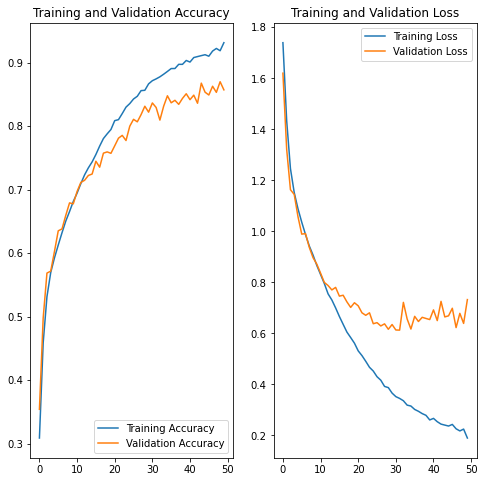

In [69]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: 6
2/2 [==============================] - 1s 16ms/step
predicted label: 6


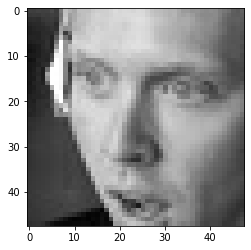

In [70]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [71]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


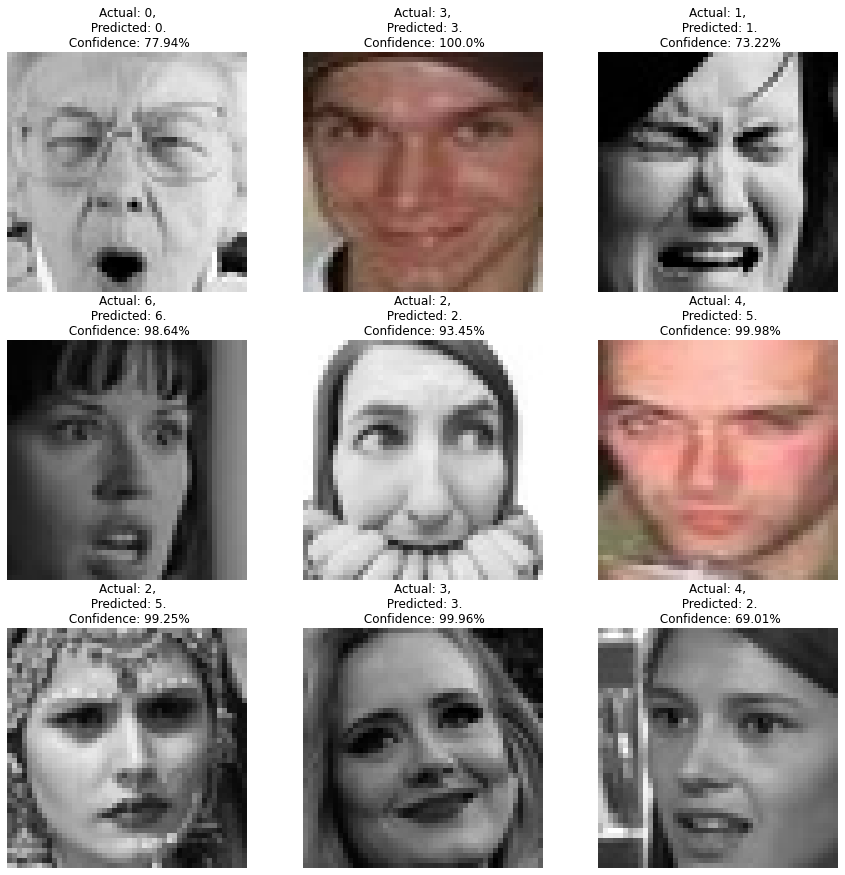

In [72]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [74]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"C:/Users/HARSHAL/models/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/HARSHAL/models/1\assets


INFO:tensorflow:Assets written to: C:/Users/HARSHAL/models/1\assets


In [75]:

model.save("A-93-VA-85-RAF-FER.h5")

In [76]:
model = tf.keras.models.load_model("A-93-VA-85-RAF-FER.h5")

first image to predict
actual label: 3
2/2 [==============================] - 0s 13ms/step
predicted label: 3


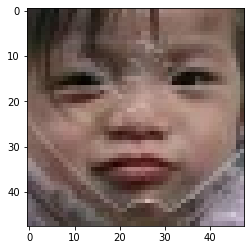

In [77]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [81]:
# plt.figure(figsize=(15, 15))
# count=0
# # for j in range(48):
#     for images, labels in test_ds.take(1):
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(images[i].numpy().astype("uint8"))
#             predicted_class, confidence = predict(model, images[i].numpy())
#             actual_class = class_names[labels[i]] 
#             if(predicted_class==actual_class):
#                 count=count+1;
# ta=count/(1536)
# print("Testing Accuracy of our model is =>",ta)
        
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
#         plt.axis("off")
count=0
total=0
plt.figure(figsize=(15, 15))
# for j in range(2):
for images, labels in test_ds.take(48):
    for i in range(32):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        if(predicted_class==actual_class):
            count=count+1
        total=total+1
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

#         plt.axis("off")

ta=count/(total) 
print("Total testing images =>",total)
print("Testing Accuracy of our model is =>",ta)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 29ms/step
Total testing images => 1536
Testing Accuracy of our model is => 0.8489583333333334


<Figure size 1080x1080 with 0 Axes>

In [82]:
len(test_ds)

82

In [83]:
82*50

4100

In [84]:
ta=count/(total)
print("Testing Accuracy of our model is =>",ta)

Testing Accuracy of our model is => 0.8489583333333334
